# 1. Data Visualization

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as la
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import seaborn as sb
sns.set_style('darkgrid')

In [2]:
# Modeling machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, lars_path
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB

from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve,f1_score

In [4]:
data = pd.read_csv('datasets/airline_data.csv')

In [5]:
data.head(20)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0
5,satisfied,Male,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,...,2,2,5,4,5,5,4,2,0,0.0
6,satisfied,Female,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,...,5,5,5,0,5,5,5,3,17,15.0
7,satisfied,Male,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,...,2,2,3,3,4,5,4,2,0,0.0
8,satisfied,Female,Loyal Customer,56,Personal Travel,Business,73,0,0,0,...,5,4,4,0,1,5,4,4,0,0.0
9,satisfied,Male,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,...,2,2,2,4,5,3,4,2,30,26.0


In [6]:
data.describe()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1981.409055,2.838597,2.990645,2.851994,2.990422,3.249130,3.383477,3.519703,3.472105,3.465075,3.485902,3.695673,3.340807,3.705759,3.352587,14.713713,15.091129
std,15.119360,1027.115606,1.392983,1.527224,1.443729,1.305970,1.318818,1.346059,1.306511,1.305560,1.270836,1.292226,1.156483,1.260582,1.151774,1.298715,38.071126,38.465650
min,7.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1359.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,1925.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000
75%,51.000000,2544.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,6951.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


Text(0, 0.5, 'Frequency')

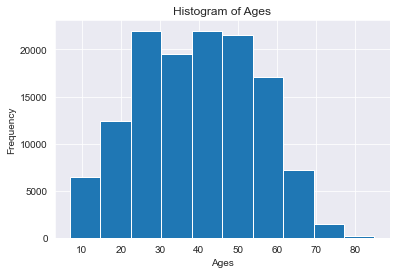

In [7]:
#Age Distribution
data['Age'].hist(bins=10)
plt.title("Histogram of Ages")
plt.xlabel('Ages')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

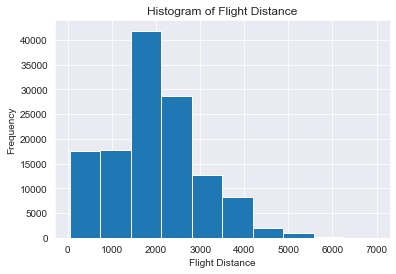

In [8]:
#Flight Distance
data['Flight Distance'].hist(bins=10)
plt.title("Histogram of Flight Distance")
plt.xlabel('Flight Distance')
plt.ylabel('Frequency')

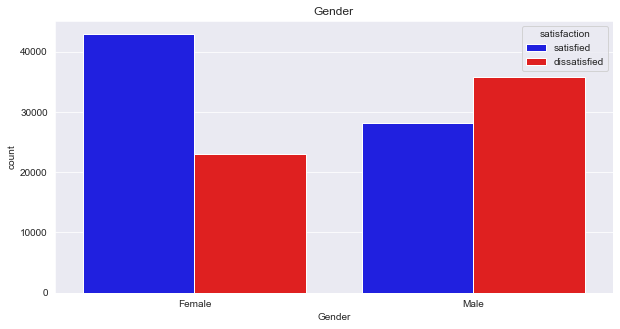

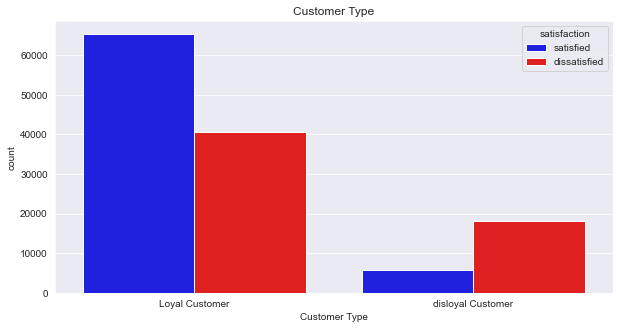

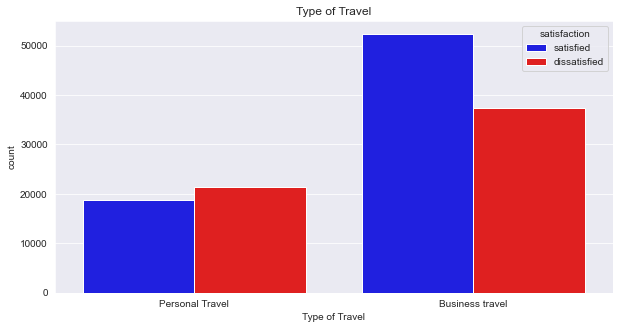

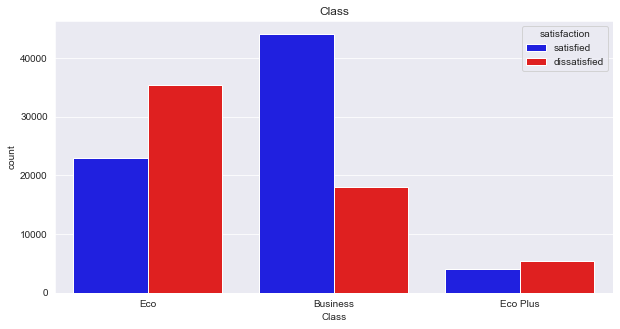

In [9]:
#Analyze object data
for col in data.select_dtypes(include = 'object'):
    if col != 'satisfaction':
        plt.figure(figsize = (10, 5))
        plt.title(col)
        sb.countplot(x = col, data = data, hue = 'satisfaction', palette = ['blue', 'red'])
        plt.show()

In [10]:
#Check the mean values
data.groupby('satisfaction').mean()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
satisfaction,,,,,,,,,,,,,,,,,,
dissatisfied,37.466671,2025.709234,2.467335,3.016686,2.660419,3.007756,2.919854,2.608644,2.959213,2.852261,2.973126,3.052625,3.364601,2.971850,3.377324,2.869695,17.807749,18.504599
satisfied,41.050051,1944.770281,3.145653,2.969108,3.010438,2.976086,3.521460,4.024308,3.983260,3.984751,3.871946,3.844247,3.969488,3.645955,3.977394,3.751966,12.154768,12.268883


In [11]:
data.groupby(['satisfaction', 'Gender']).mean()

Age  Flight Distance  Seat comfort  \
satisfaction Gender                                             
dissatisfied Female  36.899264      1925.058030      2.570720   
             Male    37.830523      2090.252219      2.401038   
satisfied    Female  40.575335      1824.189829      3.133875   
             Male    41.773749      2128.593487      3.163607   

                     Departure/Arrival time convenient  Food and drink  \
satisfaction Gender                                                      
dissatisfied Female                           2.799138        2.825127   
             Male                             3.156189        2.554799   
satisfied    Female                           2.972559        2.995644   
             Male                             2.963848        3.032991   

                     Gate location  Inflight wifi service  \
satisfaction Gender                                         
dissatisfied Female       3.059902               2.917374   
             Male         2.974317               2.921445   
satisfied    Female       2.975028               3.489284   
             Male         2.977698               3.570510   

                     Inflight entertainment  Online support  \
satisfaction Gender                                           
dissatisfied Female                2.780549        3.004136   
             Male                  2.498409        2.930406   
satisfied    Female                3.993105        3.973723   
             Male                  4.071878        3.997798   

                     Ease of Online booking  On-board service  \
satisfaction Gender                                             
dissatisfied Female                2.799748          2.843585   
             Male                  2.885936          3.056195   
satisfied    Female                3.994083          3.907380   
             Male                  3.970525          3.817927   

                     Leg room service  Baggage handling  Checkin service  \
satisfaction Gender                                                        
dissatisfied Female          2.979191          3.200296         2.844064   
             Male            3.099715          3.469963         3.053794   
satisfied    Female          3.896478          3.990589         3.641889   
             Male            3.764622          3.937320         3.652154   

                     Cleanliness  Online boarding  Departure Delay in Minutes  \
satisfaction Gender                                                             
dissatisfied Female     3.204954         2.828175                   19.646032   
             Male       3.487857         2.896321                   16.628943   
satisfied    Female     3.999953         3.726263                   11.873346   
             Male       3.943002         3.791150                   12.583792   

                     Arrival Delay in Minutes  
satisfaction Gender                            
dissatisfied Female                 20.550603  
             Male                   17.191983  
satisfied    Female                 12.093320  
             Male                   12.536446

In [12]:
data.groupby(['satisfaction', 'Customer Type']).mean()

Age  Flight Distance  Seat comfort  \
satisfaction Customer Type                                                 
dissatisfied Loyal Customer     40.286493      2028.829244      2.500160   
             disloyal Customer  31.116925      2018.683518      2.393418   
satisfied    Loyal Customer     42.193938      1936.940554      3.095172   
             disloyal Customer  27.928070      2034.588246      3.724737   

                                Departure/Arrival time convenient  \
satisfaction Customer Type                                          
dissatisfied Loyal Customer                              3.341979   
             disloyal Customer                           2.284181   
satisfied    Loyal Customer                              2.990166   
             disloyal Customer                           2.727544   

                                Food and drink  Gate location  \
satisfaction Customer Type                                      
dissatisfied Loyal Customer           2.778572       2.993147   
             disloyal Customer        2.394358       3.040653   
satisfied    Loyal Customer           2.951749       2.989249   
             disloyal Customer        3.683684       2.825088   

                                Inflight wifi service  Inflight entertainment  \
satisfaction Customer Type                                                      
dissatisfied Loyal Customer                  2.874561                2.690345   
             disloyal Customer               3.021847                2.424668   
satisfied    Loyal Customer                  3.556716                4.058834   
             disloyal Customer               3.117018                3.628246   

                                Online support  Ease of Online booking  \
satisfaction Customer Type                                               
dissatisfied Loyal Customer           2.941149                2.767961   
             disloyal Customer        2.999889                3.042091   
satisfied    Loyal Customer           4.066772                4.060639   
             disloyal Customer        3.025263                3.114211   

                                On-board service  Leg room service  \
satisfaction Customer Type                                           
dissatisfied Loyal Customer             2.923538          3.001081   
             disloyal Customer          3.084790          3.168695   
satisfied    Loyal Customer             3.885665          3.884243   
             disloyal Customer          3.714561          3.385439   

                                Baggage handling  Checkin service  \
satisfaction Customer Type                                          
dissatisfied Loyal Customer             3.275858         2.931987   
             disloyal Customer          3.564436         3.061615   
satisfied    Loyal Customer             3.957637         3.638307   
             disloyal Customer          4.105439         3.733684   

                                Cleanliness  Online boarding  \
satisfaction Customer Type                                     
dissatisfied Loyal Customer        3.290399         2.788520   
             disloyal Customer     3.573064         3.052489   
satisfied    Loyal Customer        3.966446         3.809947   
             disloyal Customer     4.102982         3.086842   

                                Departure Delay in Minutes  \
satisfaction Customer Type                                   
dissatisfied Loyal Customer                      18.722128   
             disloyal Customer                   15.748728   
satisfied    Loyal Customer                      12.105021   
             disloyal Customer                   12.725439   

                                Arrival Delay in Minutes  
satisfaction Customer Type                                
dissatisfied Loyal Customer                    19.454767  
             disloyal Customer                 16.365639  
satisfied    

In [13]:
data.groupby(['satisfaction', 'Type of Travel']).mean()

Age  Flight Distance  Seat comfort  \
satisfaction Type of Travel                                              
dissatisfied Business travel  36.853363      2045.371187      2.401103   
             Personal Travel  38.533930      1991.494174      2.582588   
satisfied    Business travel  42.040855      2080.385037      3.123692   
             Personal Travel  38.280604      1565.706369      3.207036   

                              Departure/Arrival time convenient  \
satisfaction Type of Travel                                       
dissatisfied Business travel                           2.634732   
             Personal Travel                           3.681348   
satisfied    Business travel                           2.909046   
             Personal Travel                           3.136992   

                              Food and drink  Gate location  \
satisfaction Type of Travel                                   
dissatisfied Business travel        2.724697       3.036130   
             Personal Travel        2.548565       2.958380   
satisfied    Business travel        2.995340       2.978493   
             Personal Travel        3.052640       2.969356   

                              Inflight wifi service  Inflight entertainment  \
satisfaction Type of Travel                                                   
dissatisfied Business travel               2.857327                2.599138   
             Personal Travel               3.028663                2.625186   
satisfied    Business travel               3.557758                4.065647   
             Personal Travel               3.419999                3.908761   

                              Online support  Ease of Online booking  \
satisfaction Type of Travel                                            
dissatisfied Business travel        2.893403                2.734714   
             Personal Travel        3.073732                3.056814   
satisfied    Business travel        4.025346                4.036577   
             Personal Travel        3.865624                3.839891   

                              On-board service  Leg room service  \
satisfaction Type of Travel                                        
dissatisfied Business travel          2.778424          2.927739   
             Personal Travel          3.311941          3.269948   
satisfied    Business travel          3.902437          3.863359   
             Personal Travel          3.786717          3.790828   

                              Baggage handling  Checkin service  Cleanliness  \
satisfaction Type of Travel                                                    
dissatisfied Business travel          3.182420         2.760211     3.186330   
             Personal Travel          3.681628         3.340138     3.709685   
satisfied    Business travel          3.997479         3.672091     3.999045   
             Personal Travel          3.891250         3.572901     3.916876   

                              Online boarding  Departure Delay in Minutes  \
satisfaction Type of Travel                                                 
dissatisfied Business travel         2.750435                   17.572381   
             Personal Travel         3.077228                   18.217328   
satisfied    Business travel         3.795955                   12.933245   
             Personal Travel         3.629011                    9.978805   

                              Arrival Delay in Minutes  
satisfaction Type of Travel                             
dissatisfied Business travel                 18.409098  
             Personal Travel                 18.671035  
satisfied    Business travel                 12.981554  
             Personal Travel                 10.276573

In [14]:
data.groupby(['satisfaction', 'Class']).mean()

Age  Flight Distance  Seat comfort  \
satisfaction Class                                                
dissatisfied Business  39.180736      2192.377526      2.416551   
             Eco       36.448664      1955.563193      2.491510   
             Eco Plus  38.395401      1927.010757      2.479043   
satisfied    Business  42.615489      2143.697880      2.942851   
             Eco       38.373090      1622.273843      3.464632   
             Eco Plus  39.176412      1605.630754      3.547400   

                       Departure/Arrival time convenient  Food and drink  \
satisfaction Class                                                         
dissatisfied Business                           2.843842        2.801716   
             Eco                                3.081022        2.580428   
             Eco Plus                           3.174147        2.711239   
satisfied    Business                           2.921510        2.978002   
             Eco                                3.055413        3.079267   
             Eco Plus                           2.998009        2.972879   

                       Gate location  Inflight wifi service  \
satisfaction Class                                            
dissatisfied Business       2.997564               2.882701   
             Eco            3.014801               2.950872   
             Eco Plus       2.995734               2.841061   
satisfied    Business       2.980247               3.521079   
             Eco            2.967875               3.502764   
             Eco Plus       2.977358               3.632496   

                       Inflight entertainment  Online support  \
satisfaction Class                                              
dissatisfied Business                2.763465        2.973817   
             Eco                     2.539733        2.965135   
             Eco Plus                2.541543        2.871476   
satisfied    Business                4.129108        4.097403   
             Eco                     3.854394        3.786706   
             Eco Plus                3.845733        3.854441   

                       Ease of Online booking  On-board service  \
satisfaction Class                                                
dissatisfied Business                2.675394          2.886078   
             Eco                     2.949032          3.028300   
             Eco Plus                2.810645          2.903190   
satisfied    Business                4.054110          4.023699   
             Eco                     3.853437          3.641579   
             Eco Plus                3.974372          3.523762   

                       Leg room service  Baggage handling  Checkin service  \
satisfaction Class                                                           
dissatisfied Business          2.869250          3.194354         2.899197   
             Eco               3.138782          3.451607         3.024366   
             Eco Plus          3.102374          3.364800         2.871105   
satisfied    Business          3.990997          4.123710         3.782833   
             Eco               3.619553          3.740783         3.437078   
             Eco Plus          3.518537          3.584723         3.338144   

                       Cleanliness  Online boarding  \
satisfaction Class                                    
dissatisfied Business     3.195129         2.707224   
             Eco          3.468021         2.958626   
             Eco Plus     3.393361         2.831231   
satisfied    Business     4.126046         3.811385   
             Eco          3.756801         3.640709   
             Eco Plus     3.607365         3.736004   

                       Departure Delay in Minutes  Arrival Delay in Minutes  
satisfaction Class                                                           
dissatisfied Business                   17.696208                 18.393549  
             Eco    

In [15]:
correlation_matrix = data.corr()
correlation_matrix

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
Age,1.000000,-0.249625,0.008784,0.039055,0.015749,-0.000547,0.013965,0.130511,0.121201,0.071594,0.066704,0.083762,-0.015452,0.031845,-0.018271,0.037973,-0.009041,-0.011248
Flight Distance,-0.249625,1.000000,-0.042409,0.001350,-0.004649,-0.002409,0.012230,-0.027542,-0.032022,-0.022299,-0.032559,-0.030316,0.019768,0.002456,0.009432,0.009604,0.112555,0.110103
Seat comfort,0.008784,-0.042409,1.000000,0.434951,0.715997,0.405300,0.129131,0.426447,0.120278,0.211531,0.121149,0.136136,0.118489,0.041214,0.108475,0.130396,-0.023817,-0.025506
Departure/Arrival time convenient,0.039055,0.001350,0.434951,1.000000,0.527381,0.544259,-0.001974,0.077203,-0.000546,0.001755,0.060446,0.029422,0.067396,0.062794,0.067126,-0.000623,0.004395,0.002599
Food and drink,0.015749,-0.004649,0.715997,0.527381,1.000000,0.523328,0.025917,0.367669,0.028554,0.041189,0.038646,0.074161,0.036370,0.011898,0.033416,0.013587,-0.013433,-0.014881
Gate location,-0.000547,-0.002409,0.405300,0.544259,0.523328,1.000000,-0.004086,-0.000280,0.002908,0.001442,-0.025132,-0.007407,-0.000401,-0.031859,-0.001705,-0.003043,0.003962,0.003640
Inflight wifi service,0.013965,0.012230,0.129131,-0.001974,0.025917,-0.004086,1.000000,0.253823,0.557340,0.601100,0.060794,0.033589,0.038251,0.092508,0.038263,0.631786,-0.032900,-0.035270
Inflight entertainment,0.130511,-0.027542,0.426447,0.077203,0.367669,-0.000280,0.253823,1.000000,0.441957,0.321731,0.183912,0.160731,0.117213,0.224120,0.109451,0.355714,-0.030491,-0.033321
Online support,0.121201,-0.032022,0.120278,-0.000546,0.028554,0.002908,0.557340,0.441957,1.000000,0.617489,0.157930,0.138433,0.102444,0.206824,0.095726,0.669843,-0.034018,-0.036087
Ease of Online booking,0.071594,-0.022299,0.211531,0.001755,0.041189,0.001442,0.601100,0.321731,0.617489,1.000000,0.436264,0.355122,0.398322,0.137744,0.417675,0.684320,-0.036545,-0.039806


Text(0.5, 1.0, 'Correlation Heatmap')

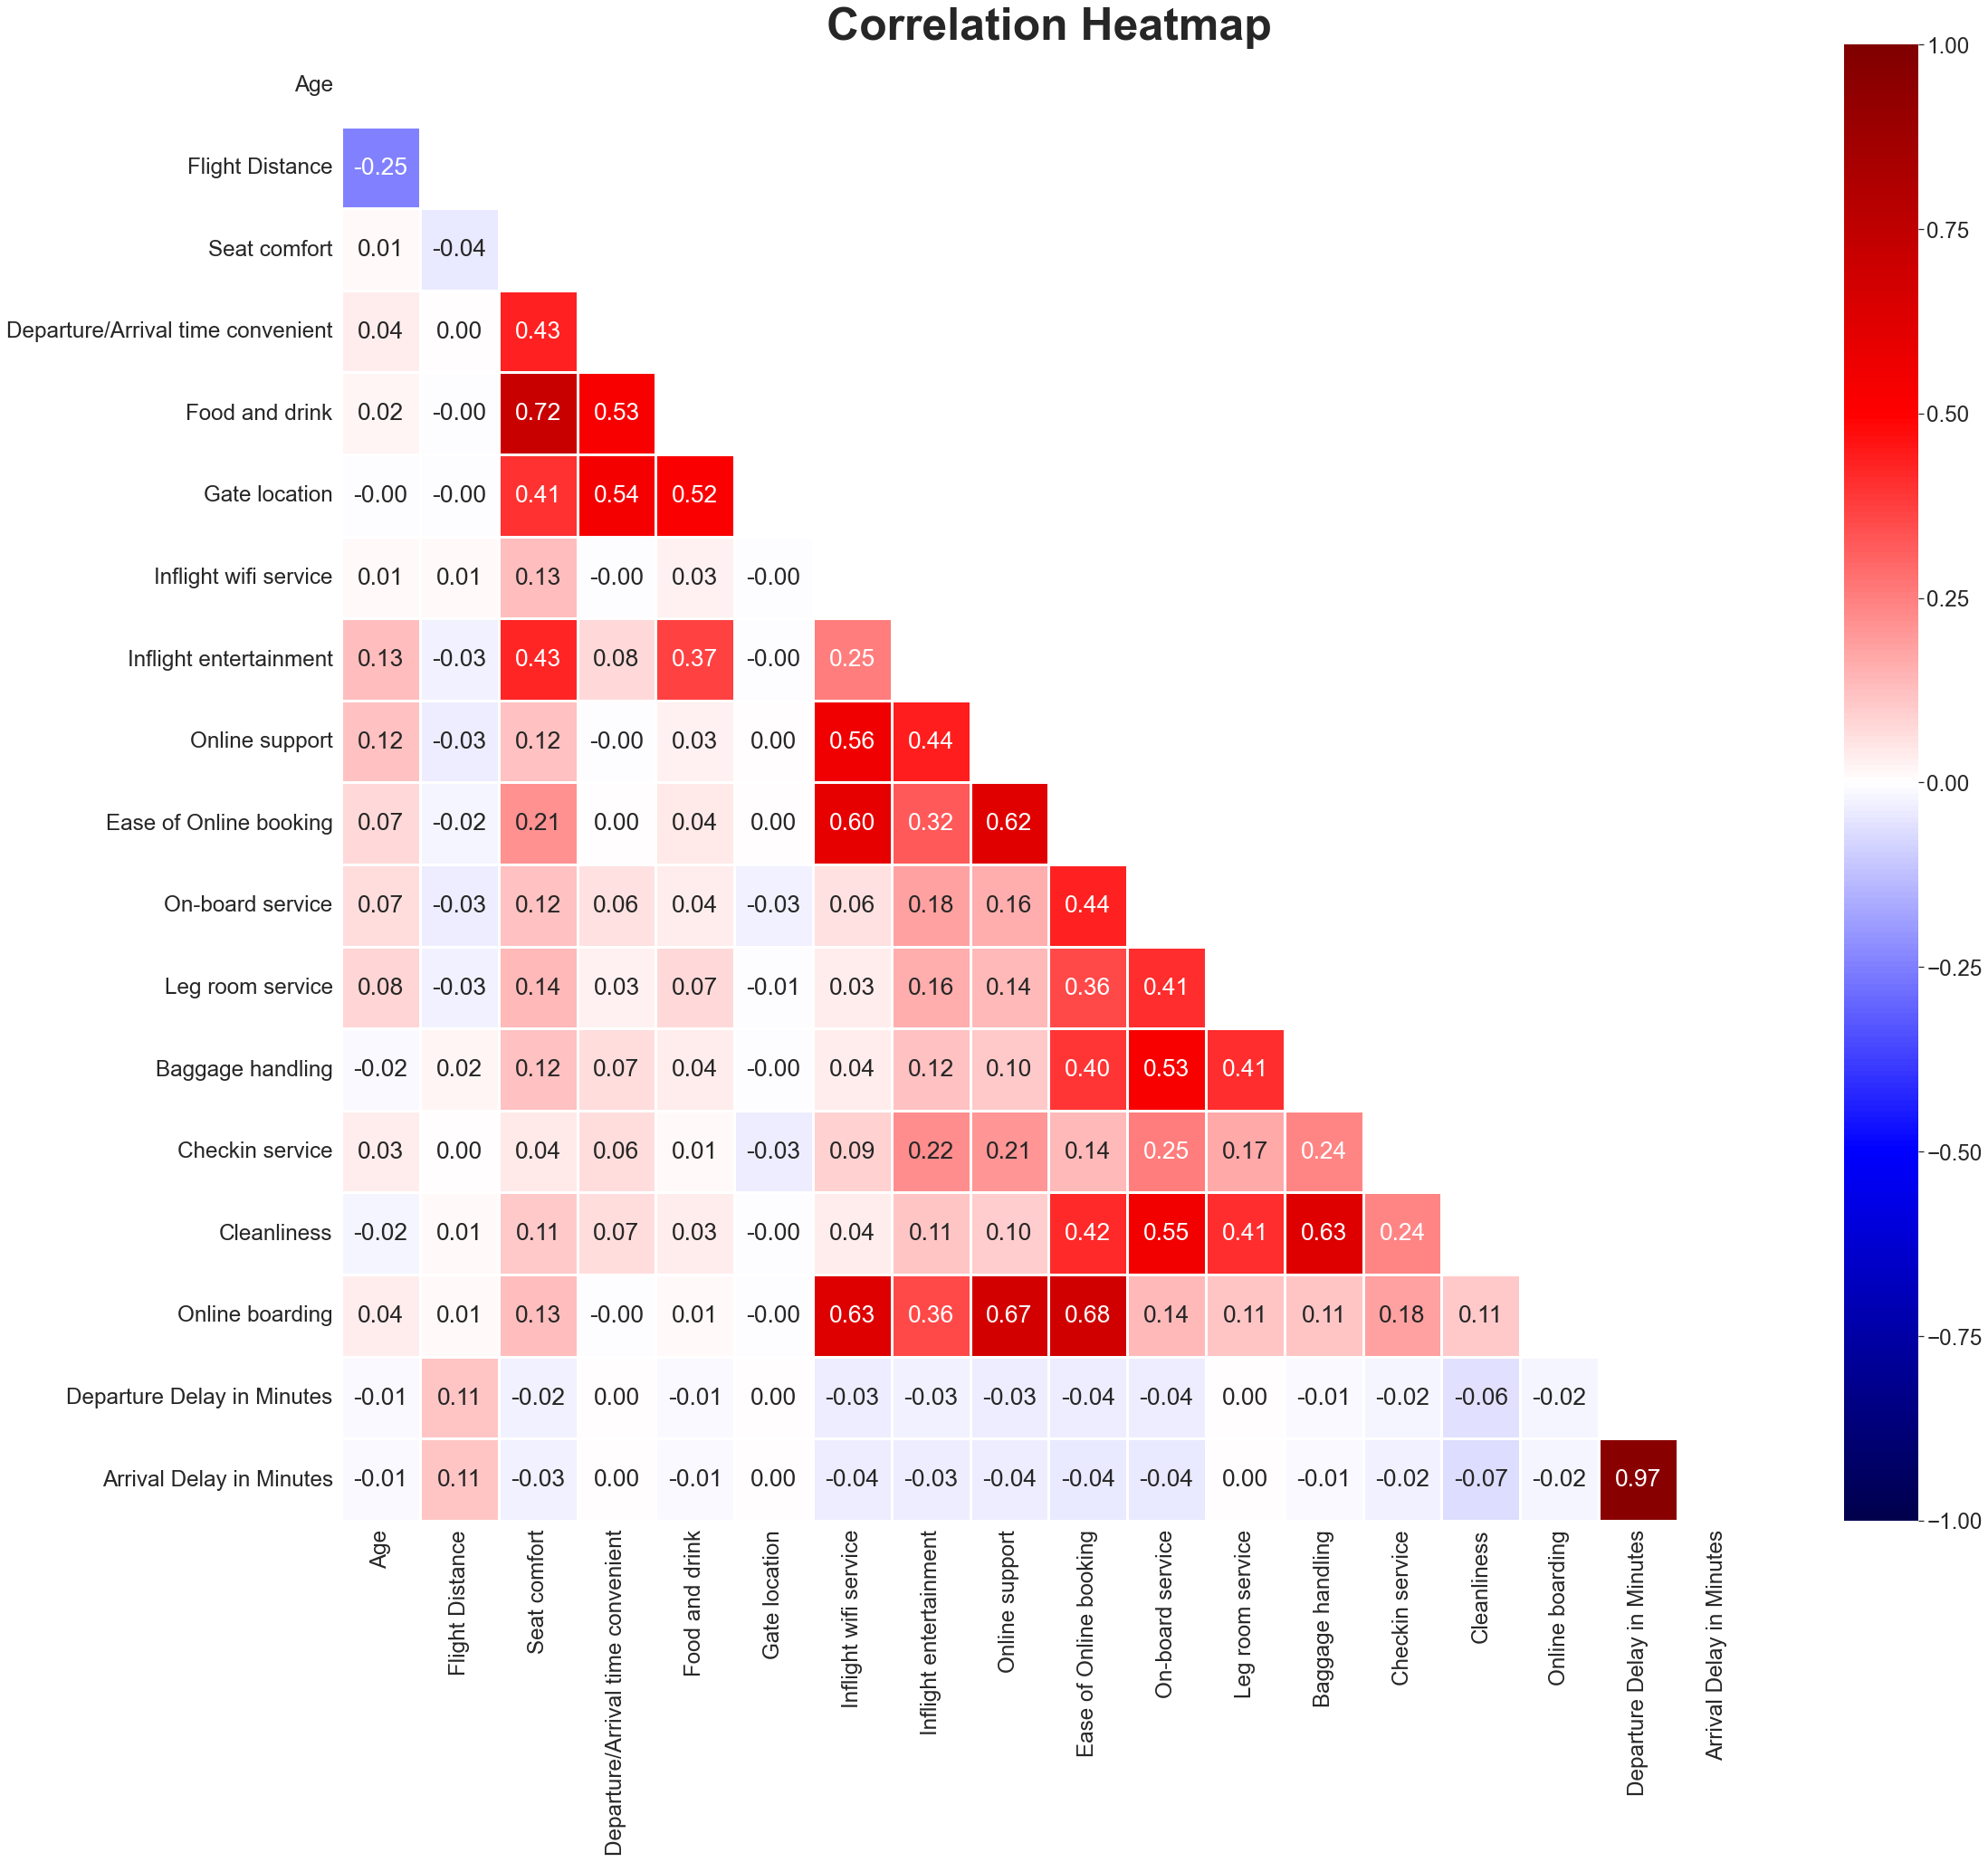

In [56]:
sns.set(style='white',font_scale=2.2)
fig = plt.figure(figsize=[35,30])
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(150, 0, as_cmap=True)
sns.heatmap(correlation_matrix,cmap='seismic',linewidth=3,linecolor='white',vmax = 1, vmin=-1,mask=mask, annot=True,fmt='0.2f')
plt.title('Correlation Heatmap', weight='bold',fontsize=50)

# 2. Data Preprocessing

In [17]:
def preprocess(df):
    df = df.copy() #we want to create a copy of the dataframe
    df['Arrival Delay in Minutes'] =df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mean())
    
    #To distinguish binary variables, we are going to use binary classification
    df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
    df['Customer Type'] = df['Customer Type'].replace({'disloyal Customer': 0, 'Loyal Customer': 1})
    df['Type of Travel'] = df['Type of Travel'].replace({'Personal Travel': 0, 'Business travel': 1})
    df['satisfaction'] = df['satisfaction'].replace({'satisfied': 1, 'dissatisfied': 0})
    ##################################################################
    
    #One hot coding
    flight_class = pd.get_dummies(df['Class'],prefix='Flight')
    df = pd.concat([df,flight_class],axis=1)
    df = df.drop('Class',axis=1)
    return df


In [18]:
def classify_objects(X):
    return {col: len(X[col].unique()) for col in X.select_dtypes('object').columns} ,{col: list(X[col].unique()) for col in X.select_dtypes('object').columns}

In [19]:
class_len, class_list = classify_objects(data) #after preprocessing all the data, we are going to classify them into data classes
print('class_len:',class_len)
print('class_list:',class_list)

class_len: {'satisfaction': 2, 'Gender': 2, 'Customer Type': 2, 'Type of Travel': 2, 'Class': 3}
class_list: {'satisfaction': ['satisfied', 'dissatisfied'], 'Gender': ['Female', 'Male'], 'Customer Type': ['Loyal Customer', 'disloyal Customer'], 'Type of Travel': ['Personal Travel', 'Business travel'], 'Class': ['Eco', 'Business', 'Eco Plus']}


In [20]:
X = preprocess(data)
X

,satisfaction,Gender,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Flight_Business,Flight_Eco,Flight_Eco Plus
0,1,0,1,65,0,265,0,0,0,2,...,0,3,5,3,2,0,0.0,0,1,0
1,1,1,1,47,0,2464,0,0,0,3,...,4,4,2,3,2,310,305.0,1,0,0
2,1,0,1,15,0,2138,0,0,0,3,...,3,4,4,4,2,0,0.0,0,1,0
3,1,0,1,60,0,623,0,0,0,3,...,0,1,4,1,3,0,0.0,0,1,0
4,1,0,1,70,0,354,0,0,0,3,...,0,2,4,2,5,0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1,0,0,29,0,1731,5,5,5,3,...,3,4,4,4,2,0,0.0,0,1,0
129876,0,1,0,63,0,2087,2,3,2,4,...,3,3,1,2,1,174,172.0,1,0,0
129877,0,1,0,69,0,2320,3,0,3,3,...,3,4,2,3,2,155,163.0,0,1,0
129878,0,1,0,66,0,2450,3,2,3,2,...,2,3,2,1,2,193,205.0,0,1,0


# 3. Dataset Preparation

In [28]:
data

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,satisfied,Female,disloyal Customer,29,Personal Travel,Eco,1731,5,5,5,...,2,2,3,3,4,4,4,2,0,0.0
129876,dissatisfied,Male,disloyal Customer,63,Personal Travel,Business,2087,2,3,2,...,1,3,2,3,3,1,2,1,174,172.0
129877,dissatisfied,Male,disloyal Customer,69,Personal Travel,Eco,2320,3,0,3,...,2,4,4,3,4,2,3,2,155,163.0
129878,dissatisfied,Male,disloyal Customer,66,Personal Travel,Eco,2450,3,2,3,...,2,3,3,2,3,2,1,2,193,205.0


In [29]:
def prepare_dataset_train(df):
    df = preprocess(df)
    # Scaling the continuos variables: `Age` and `Flight Distance`.
    df.loc[:,["Age","Flight Distance"]] = StandardScaler().fit_transform(df.loc[:,["Age","Flight Distance"]])
    # Scaling our categorical variables related to the satisfaction to each different aspect of the customer service
    df.loc[:,"Inflight wifi service":"Cleanliness"] = StandardScaler().fit_transform(df.loc[:,"Inflight wifi service":"Cleanliness"])
    
    return df

In [30]:
data_train_prep = prepare_dataset_train(data)

In [31]:
data_train_prep

,satisfaction,Gender,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Flight_Business,Flight_Eco,Flight_Eco Plus
0,1,0,1,1.691351,0,-1.671103,0,0,0,2,...,-2.697605,-0.601544,1.316217,-0.612761,2,0,0.0,0,1,0
1,1,1,1,0.500820,0,0.469852,0,0,0,3,...,0.397840,0.263150,-1.063645,-0.612761,2,310,305.0,1,0,0
2,1,0,1,-1.615680,0,0.152458,0,0,0,3,...,-0.376021,0.263150,0.522929,0.255469,2,0,0.0,0,1,0
3,1,0,1,1.360648,0,-1.322552,0,0,0,3,...,-2.697605,-2.330931,0.522929,-2.349219,3,0,0.0,0,1,0
4,1,0,1,2.022054,0,-1.584452,0,0,0,3,...,-2.697605,-1.466238,0.522929,-1.480990,5,0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1,0,0,-0.689712,0,-0.243799,5,5,5,3,...,-0.376021,0.263150,0.522929,0.255469,2,0,0.0,0,1,0
129876,0,1,0,1.559070,0,0.102804,2,3,2,4,...,-0.376021,-0.601544,-1.856932,-1.480990,1,174,172.0,1,0,0
129877,0,1,0,1.955913,0,0.329653,3,0,3,3,...,-0.376021,0.263150,-1.063645,-0.612761,2,155,163.0,0,1,0
129878,0,1,0,1.757491,0,0.456222,3,2,3,2,...,-1.149883,-0.601544,-1.063645,-2.349219,2,193,205.0,0,1,0


In [32]:
data_train_prep.isna().sum()

satisfaction                         0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Flight Distance                      0
Seat comfort                         0
Departure/Arrival time convenient    0
Food and drink                       0
Gate location                        0
Inflight wifi service                0
Inflight entertainment               0
Online support                       0
Ease of Online booking               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Cleanliness                          0
Online boarding                      0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Flight_Business                      0
Flight_Eco                           0
Flight_Eco Plus                      0
dtype: int64

In [33]:
X = data_train_prep.drop(['satisfaction'], axis=1)
y = data_train_prep['satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

In [34]:
X_test

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,...,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Flight_Business,Flight_Eco,Flight_Eco Plus
103044,0,1,1.294507,1,-0.497910,4,4,4,4,1.327611,...,0.397840,0.263150,1.316217,0.255469,3,7,0.0,1,0,0
43282,0,0,-1.152696,1,-0.204855,1,1,1,4,0.569353,...,0.397840,-0.601544,-1.856932,0.255469,4,0,0.0,0,1,0
65543,1,1,1.029945,1,1.631362,0,5,0,2,0.569353,...,0.397840,0.263150,-0.270358,0.255469,3,12,8.0,1,0,0
65083,0,1,0.103976,1,-0.180515,0,4,0,1,-0.947163,...,-0.376021,-0.601544,1.316217,-0.612761,3,0,0.0,1,0,0
76496,1,1,0.170117,1,-0.265219,2,3,3,3,-0.947163,...,0.397840,0.263150,-1.856932,-0.612761,2,0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32347,0,1,-1.218836,0,-0.477464,4,1,4,2,-1.705421,...,0.397840,-2.330931,-0.270358,-2.349219,1,0,0.0,0,1,0
123061,0,1,-0.094446,1,0.380281,1,1,1,1,-0.947163,...,1.171702,1.127843,1.316217,1.123698,4,21,7.0,1,0,0
74700,1,1,-0.491290,1,1.458061,2,4,4,4,-0.947163,...,-0.376021,-2.330931,0.522929,-1.480990,2,0,0.0,0,1,0
54997,1,0,-0.491290,1,0.312129,3,3,3,4,1.327611,...,-1.149883,0.263150,0.522929,1.123698,5,9,7.0,1,0,0


# 4. Machine Learning

## Supervised Learning
### 4-1. Linear Regression

In [55]:
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train) 
y_lin_pred = lm_model.predict(X_test)

rmse = mean_squared_error(y_test, y_lin_pred)
r2 = r2_score(y_test, y_lin_pred)
print('The coefficients are {}'.format(lm_model.coef_))
print()
print('The intercept is {}'.format(lm_model.intercept_))
print('Root mean squared error of the model is {}.'.format(rmse))
print('R-squared score is {}.'.format(r2))

The coefficients are [-1.37942114e-01  2.98431464e-01 -1.74658954e-02  1.06490300e-01
 -1.56504168e-02  5.06461883e-02 -3.20417631e-02 -3.42339425e-02
  1.56248723e-02 -1.03746347e-02  1.39742499e-01  1.78485720e-02
  4.54407387e-02  5.45611552e-02  3.99089301e-02  1.53565280e-02
  4.95796208e-02  1.27744750e-02  2.15262217e-02  2.88587988e-04
 -9.22354005e-04 -4.66971854e+11 -4.66971854e+11 -4.66971854e+11]

The intercept is 466971854205.44354
Root mean squared error of the model is 0.12892294338971344.
R-squared score is 0.4792077411285013.


C:\Users\LOTLOUISCHO\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [36]:
class Model:
    def __init__(self,mod_type,acc,prec,rec,f1):
        self.model_type = mod_type
        self.accuracy_score = acc
        self.precision_score = prec
        self.recall_score = rec
        self.f1_score = f1

In [37]:
all_models = []

### 4-2. Logistic Regression

In [38]:
log_model = LogisticRegression(max_iter = 1e5)
log_model.fit(X_train, y_train)
y_log_pred = log_model.predict(X_test)

mod_type = 'Logistic'
acc = accuracy_score(y_test, y_log_pred)
prec = precision_score(y_test, y_log_pred)
rec = recall_score(y_test, y_log_pred)
f1 = f1_score(y_test, y_log_pred)

Log_obj = Model(mod_type,acc,prec,rec,f1)
all_models.append(Log_obj)

In [39]:
print(f"Accuracy score: {accuracy_score(y_test, y_log_pred)*100:0.1f}%")
print(f"Precision score: {precision_score(y_test, y_log_pred)*100:0.1f}%")
print(f"Recall score: {recall_score(y_test, y_log_pred)*100:0.1f}%")
print(f"F1 score: {f1_score(y_test, y_log_pred)*100:0.1f}%")

Accuracy score: 83.6%
Precision score: 85.2%
Recall score: 84.9%
F1 score: 85.1%


### 4-3. Decision Tree Classifier

In [40]:
dt_model = DecisionTreeClassifier(max_depth=None)
dt_model.fit(X_train,y_train)
dt_model_training_score = 100*dt_model.score(X_train, y_train)
y_dt_pred = dt_model.predict(X_test)
dt_model_test_score = 100*dt_model.score(X_test, y_test)

mod_type = 'Decision_Tree'
acc = accuracy_score(y_test, y_dt_pred)
prec = precision_score(y_test, y_dt_pred)
rec = recall_score(y_test, y_dt_pred)
f1 = f1_score(y_test, y_dt_pred)

Tree_obj = Model(mod_type,acc,prec,rec,f1)
all_models.append(Tree_obj)

In [41]:
print ('Tree Depth:', dt_model.get_depth())
print ('Tree Leaves:', dt_model.get_n_leaves())
print("Decision Tree accuracy. Train : {:.2f}%, Test: {:.2f}%. ".format(dt_model_training_score, dt_model_test_score))
print()
print(f"Accuracy score: {accuracy_score(y_test, y_dt_pred)*100:0.1f}%")
print(f"Precision score: {precision_score(y_test, y_dt_pred)*100:0.1f}%")
print(f"Recall score: {recall_score(y_test, y_dt_pred)*100:0.1f}%")
print(f"F1 score: {f1_score(y_test, y_dt_pred)*100:0.1f}%")

Tree Depth: 35
Tree Leaves: 4108
Decision Tree accuracy. Train : 100.00%, Test: 93.88%. 

Accuracy score: 93.9%
Precision score: 94.2%
Recall score: 94.7%
F1 score: 94.4%


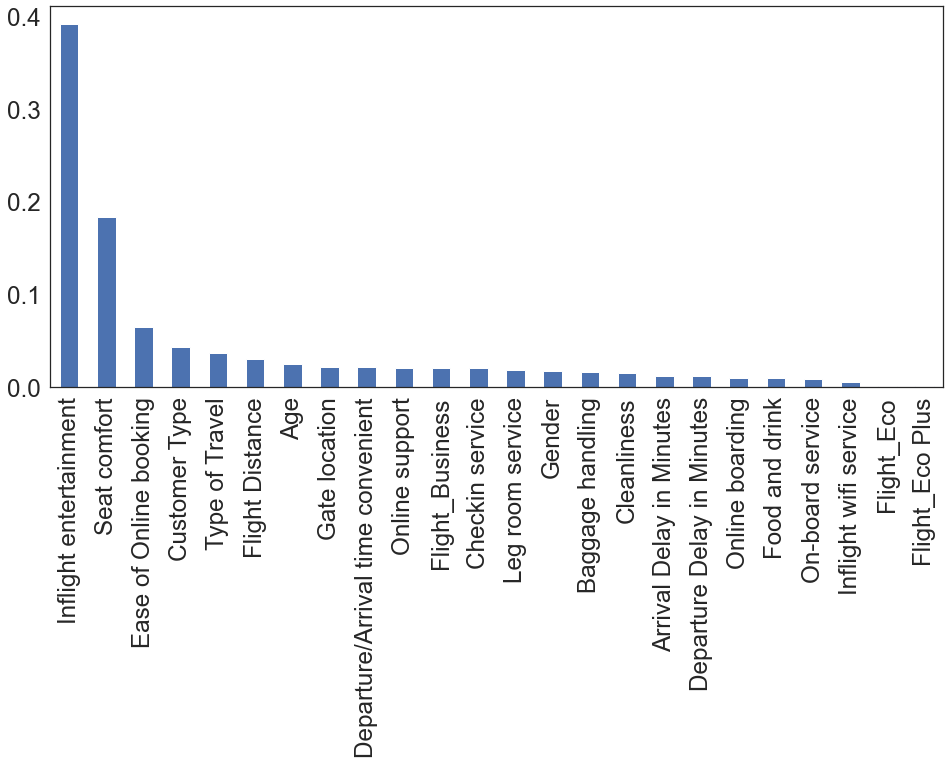

In [42]:
ax = pd.Series(dt_model.feature_importances_,index=X_train.columns).sort_values(ascending=False).plot.bar(figsize=(16,7))
ax.grid(False)

### 4-4. Random Forest Classifier

In [43]:
rfc_model =RandomForestClassifier(max_depth=2, random_state=0)
rfc_model.fit(X_train, y_train)
y_rfc_pred = rfc_model.predict(X_test)
rfc_model_test_score = 100*rfc_model.score(X_test, y_test)

mod_type = 'Random_Forest'
acc = accuracy_score(y_test, y_rfc_pred)
prec = precision_score(y_test, y_rfc_pred)
rec = recall_score(y_test, y_rfc_pred)
f1 = f1_score(y_test, y_rfc_pred)

Forest_obj = Model(mod_type,acc,prec,rec,f1)
all_models.append(Forest_obj)

In [44]:
print(f"Accuracy score: {accuracy_score(y_test, y_rfc_pred)*100:0.1f}%")
print(f"Precision score: {precision_score(y_test, y_rfc_pred)*100:0.1f}%")
print(f"Recall score: {recall_score(y_test, y_rfc_pred)*100:0.1f}%")
print(f"F1 score: {f1_score(y_test, y_rfc_pred)*100:0.1f}%")

Accuracy score: 85.1%
Precision score: 84.7%
Recall score: 89.1%
F1 score: 86.8%


### 4-5. K-Nearest Neighbors Classifier

In [45]:
knn_model = KNeighborsClassifier(7)
knn_model.fit(X_train, y_train)
y_knn_pred = knn_model.predict(X_test)

mod_type = 'KNN'
acc = accuracy_score(y_test, y_knn_pred)
prec = precision_score(y_test, y_knn_pred)
rec = recall_score(y_test, y_knn_pred)
f1 = f1_score(y_test, y_knn_pred)

KNN_obj = Model(mod_type,acc,prec,rec,f1)
all_models.append(KNN_obj)

In [46]:
print(f"Accuracy score: {accuracy_score(y_test, y_knn_pred)*100:0.1f}%")
print(f"Precision score: {precision_score(y_test, y_knn_pred)*100:0.1f}%")
print(f"Recall score: {recall_score(y_test, y_knn_pred)*100:0.1f}%")
print(f"F1 score: {f1_score(y_test, y_knn_pred)*100:0.1f}%")

Accuracy score: 88.4%
Precision score: 90.7%
Recall score: 88.0%
F1 score: 89.3%


### 4-6. Gaussian Naive Bayes Classifier

In [48]:
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
y_gnb_pred = gnb_model.predict(X_test)

mod_type = 'GNB'
acc = accuracy_score(y_test, y_gnb_pred)
prec = precision_score(y_test, y_gnb_pred)
rec = recall_score(y_test, y_gnb_pred)
f1 = f1_score(y_test, y_gnb_pred)

GNB_obj = Model(mod_type,acc,prec,rec,f1)
all_models.append(GNB_obj)

In [49]:
print(f"Accuracy score: {accuracy_score(y_test, y_gnb_pred)*100:0.1f}%")
print(f"Precision score: {precision_score(y_test, y_gnb_pred)*100:0.1f}%")
print(f"Recall score: {recall_score(y_test, y_gnb_pred)*100:0.1f}%")
print(f"F1 score: {f1_score(y_test, y_gnb_pred)*100:0.1f}%")

Accuracy score: 81.7%
Precision score: 83.5%
Recall score: 83.2%
F1 score: 83.3%


### 4-7. Model Selection Bar Chart

In [50]:
model_list = []

for model in all_models:
    scores = [model.accuracy_score,model.precision_score,model.recall_score,model.f1_score]
    scoring = ['Accuracy','Precision','Recall','F1']
    idx = 0
    for score in scoring:
        dic = {'Model':model.model_type,'Scoring':score,'Score':scores[idx]}
        model_list.append(dic)
        idx +=1

In [51]:
model_df = pd.DataFrame(model_list)
model_df

,Model,Scoring,Score
0,Logistic,Accuracy,0.836233
1,Logistic,Precision,0.852281
2,Logistic,Recall,0.849136
3,Logistic,F1,0.850705
4,Decision_Tree,Accuracy,0.938815
5,Decision_Tree,Precision,0.942054
6,Decision_Tree,Recall,0.946894
7,Decision_Tree,F1,0.944468
8,Random_Forest,Accuracy,0.851299
9,Random_Forest,Precision,0.846591


Text(0.5, 1.0, 'Performance Across Models')

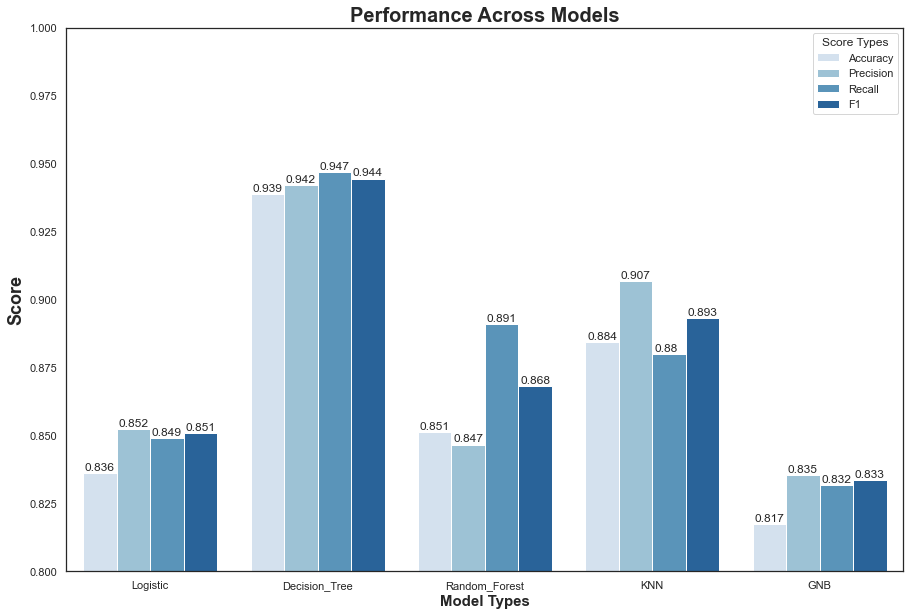

In [52]:
sns.set(style='white',font_scale=1)
fig = plt.figure(figsize=[15,10])
graph = sns.barplot(x='Model',y='Score',data=model_df,hue='Scoring',palette='Blues')
for elem in graph.patches:
    graph.annotate(elem.get_height().round(3), (elem.get_x()+0.01, elem.get_height()+0.001))
    
plt.legend(title='Score Types')
plt.ylim([0.8,1.0])
plt.xlabel('Model Types',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Performance Across Models',weight='bold',fontsize=20)

## Unsupervised Learning
### 4-8. K-Means Clustering

In [113]:
def calculate_k(distortions):
    k = 1
    tol = 0.2
    for i in range(len(distortions)-1):
        absolute_error = abs(distortions[i+1] - distortions[i])
        relative_error = absolute_error/distortions[i]
        if relative_error > tol:
            k+=1
    return k

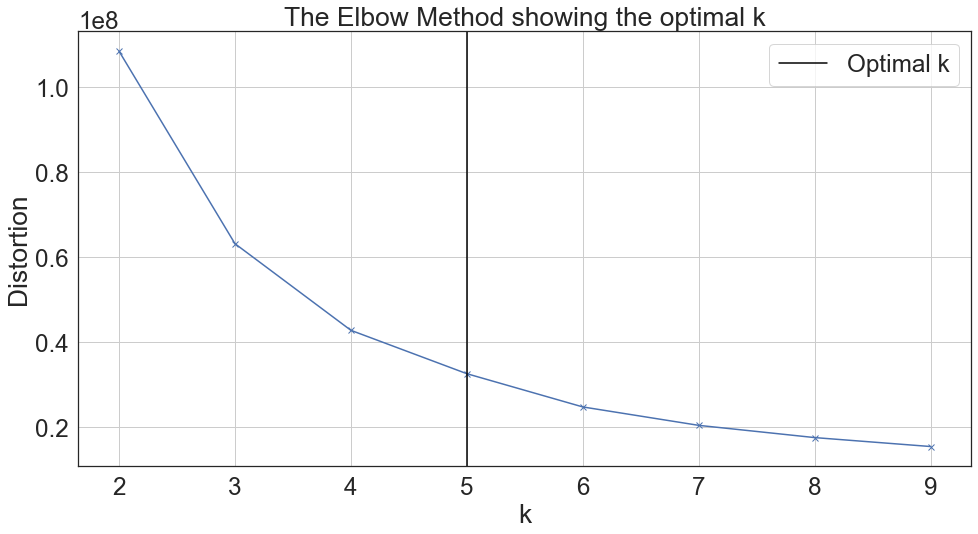

In [119]:
distortions = []
K = range(2,10)
kmeans_model = KMeans(n_clusters=1)
for k in K:
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(X_train)
    distortions.append(kmeans_model.inertia_)

optimal_k = calculate_k(distortions)
kmeans_model = KMeans(n_clusters=optimal_k)
kmeans_model.fit(X_train)
plt.figure(figsize=(16,8))
plt.grid()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.axvline(x=optimal_k, color='black', linestyle='-', label='Optimal k')
plt.legend()

In [120]:
print("Number of clusters defined:", len(set(kmeans_model.labels_)))

Number of clusters defined: 5


In [121]:
len(kmeans_model.labels_)

90916

In [122]:
airline_train_cluster = X_train

airline_train_cluster["Cluster_KMeans"] = kmean_model.labels_

airline_train_cluster

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,...,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Flight_Business,Flight_Eco,Flight_Eco Plus,Cluster_KMeans
18386,0,1,0.037835,0,-0.384972,3,3,3,3,-0.947163,...,0.263150,0.522929,0.255469,5,4,1.0,0,1,0,0
115613,0,1,0.633101,1,-0.007213,1,1,1,1,1.327611,...,1.127843,-0.270358,1.123698,4,0,0.0,1,0,0,0
68138,0,1,-1.218836,1,2.328462,1,3,3,3,-1.705421,...,0.263150,-1.063645,-0.612761,1,0,1.0,1,0,0,0
78244,1,1,0.963804,1,-0.496936,2,1,4,4,-0.188905,...,0.263150,0.522929,0.255469,3,4,6.0,0,1,0,0
34472,1,1,1.889773,0,-0.074392,4,4,4,1,-0.947163,...,0.263150,1.316217,0.255469,2,6,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128106,1,1,0.170117,1,-0.264245,3,3,3,3,-0.188905,...,1.127843,0.522929,1.123698,4,54,33.0,1,0,0,2
103694,0,1,0.765382,1,0.162194,4,5,5,5,0.569353,...,-0.601544,0.522929,0.255469,4,329,395.0,0,1,0,3
860,1,1,1.625210,0,-0.754941,1,0,1,2,-1.705421,...,1.127843,0.522929,0.255469,1,13,9.0,0,1,0,0
15795,0,1,-1.152696,0,-0.767598,3,3,3,3,-1.705421,...,0.263150,-1.856932,0.255469,4,0,0.0,0,1,0,0


In [123]:
airline_train_cluster.groupby("Cluster_KMeans").mean()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,...,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Flight_Business,Flight_Eco,Flight_Eco Plus
Cluster_KMeans,,,,,,,,,,,,,,,,,,,,,
0,0.492218,0.818735,0.009085,0.688602,-0.020734,2.851033,2.989889,2.857239,2.984787,0.013783,...,0.005805,0.010440,0.013612,0.024320,3.372318,2.779531,3.008198,0.481138,0.446660,0.072202
1,0.500880,0.804577,-0.028829,0.705106,0.981412,2.713908,3.042254,2.731514,2.982394,-0.190240,...,0.120585,-0.004784,-0.044103,-0.450732,3.285211,210.328345,212.847072,0.457746,0.475352,0.066901
2,0.495254,0.813899,-0.010818,0.699382,-0.033503,2.783245,2.972916,2.834364,2.993730,-0.041915,...,-0.034411,-0.044459,-0.056682,-0.049693,3.280066,38.108073,39.075433,0.465209,0.455978,0.078812
3,0.496241,0.842105,-0.107376,0.699248,1.002655,2.759398,3.045113,2.669173,3.037594,-0.166100,...,0.025456,0.029097,0.093481,-0.443032,3.458647,461.894737,465.240602,0.443609,0.518797,0.037594
4,0.498971,0.805713,-0.018042,0.707154,0.187889,2.756819,2.951879,2.800566,2.979156,-0.075927,...,-0.036287,-0.059275,-0.093164,-0.143568,3.269171,101.482501,102.016518,0.462944,0.455996,0.081060


In [124]:
cluster = X_train.copy()
cluster["Cluster_KMeans"] = kmeans_model.labels_

cluster.groupby("Cluster_KMeans").sum()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,...,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Flight_Business,Flight_Eco,Flight_Eco Plus
Cluster_KMeans,,,,,,,,,,,,,,,,,,,,,
0,36561,60814,674.848725,51148,-1540.080622,211769,222083,212230,221704,1023.742522,...,431.151987,775.462618,1011.080436,1806.456051,250489,206458,223442.949964,35738.0,33177.0,5363.0
1,1939,3131,-70.111654,2748,730.136216,10713,11471,10883,11577,-295.052606,...,-141.010411,-230.341419,-362.036950,-557.906870,12704,394361,396436.187092,1799.0,1772.0,315.0
2,569,914,-32.750102,801,1114.883968,3083,3456,3103,3388,-216.112339,...,136.985009,-5.434122,-50.101355,-512.031635,3732,238933,241794.273387,520.0,540.0,76.0
3,5687,9346,-124.226990,8031,-384.711995,31960,34138,32547,34377,-481.311353,...,-395.146749,-510.525717,-650.880776,-570.628475,37665,437595,448703.196761,5342.0,5236.0,905.0
4,66,112,-14.280965,93,133.353171,367,405,355,404,-22.091303,...,3.385632,3.869937,12.432939,-58.923222,460,61432,61877.000000,59.0,69.0,5.0


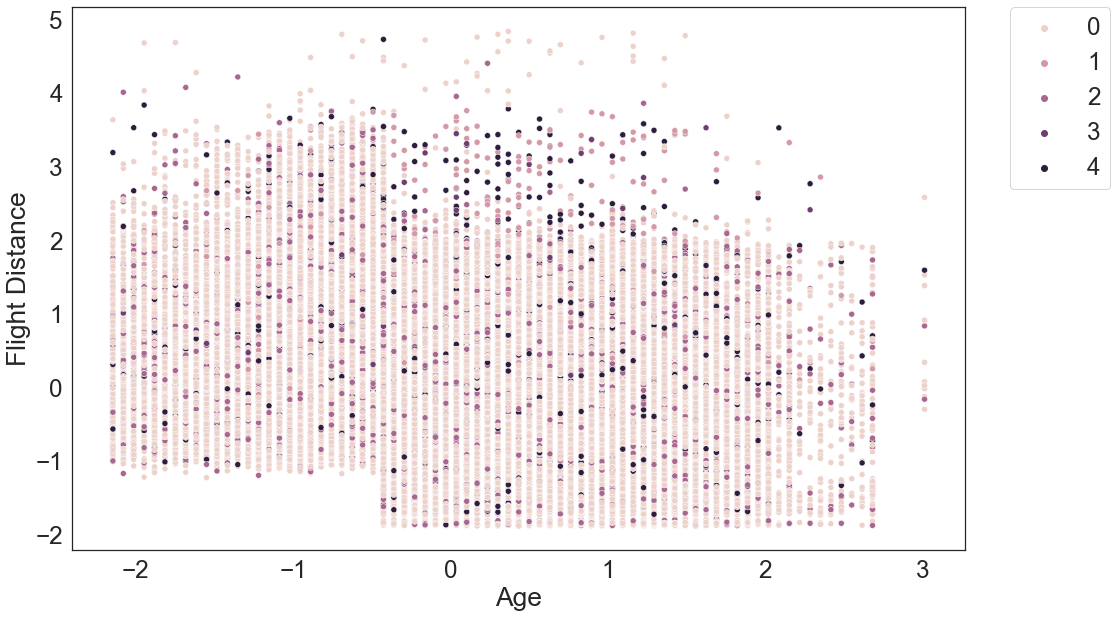

In [129]:
plt.figure(figsize=(16,10))
sns.scatterplot(data=airline_train_cluster, x="Age",y="Flight Distance",hue="Cluster_KMeans")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)